In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scanpy.external as sce
import sys


# Use random module
import random 
random.seed(10)
print(random.random()) 

0.5714025946899135


In [2]:
# https://pmc.ncbi.nlm.nih.gov/articles/PMC10132989/#notes3

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
sns.set_style("ticks")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.1 louvain==0.7.1 pynndescent==0.5.8


In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set font to Arial
rcParams['font.family'] = 'Arial'

In [5]:

# Step 1: Read the two 10x datasets
adata1 = sc.read_h5ad("/home/julia/data/RPE_MEl_resubmission/RPE_MELANO_eye_with_annotation_with_MELANO.h5ad")
adata2 = sc.read_h5ad("P0_melano.h5ad")


In [6]:
adata2.obs['cell_type']='Melano_P0'

In [7]:
# Step 2: Annotate batches
# Add batch labels to identify the origin of each dataset
adata1.obs['batch'] = 'RPE'
adata2.obs['batch'] = 'P0'

# Step 3: Merge the datasets
# Concatenate the datasets into a single AnnData object
adata_combined = adata1.concatenate(
    adata2,
    batch_key="batch",  # Creates a new "batch" column if not already present
    batch_categories=["RPE", "P0"],
    index_unique=None  , join='outer'
    # Prevents adding unique suffixes to cell barcodes
)


/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [8]:
adata_combined

AnnData object with n_obs × n_vars = 16335 × 22497
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'cells', 'cell_type', 'batch', 'leiden'
    var: 'n_cells-P0', 'mt-P0', 'n_cells_by_counts-P0', 'mean_counts-P0', 'pct_dropout_by_counts-P0', 'total_counts-P0', 'highly_variable-P0', 'means-P0', 'dispersions-P0', 'dispersions_norm-P0', 'gene_ids-RPE', 'n_cells-RPE', 'mt-RPE', 'n_cells_by_counts-RPE', 'mean_counts-RPE', 'pct_dropout_by_counts-RPE', 'total_counts-RPE'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [9]:
adata_combined.var=adata_combined.var.drop(columns = 
[ 'n_cells-P0', 'mt-P0', 'n_cells_by_counts-P0', 'mean_counts-P0', 'pct_dropout_by_counts-P0', 'total_counts-P0', 'highly_variable-P0', 'means-P0', 'dispersions-P0', 'dispersions_norm-P0', 'gene_ids-RPE', 'n_cells-RPE', 'mt-RPE', 'n_cells_by_counts-RPE', 'mean_counts-RPE', 'pct_dropout_by_counts-RPE', 'total_counts-RPE'                         ], axis = 1) 

In [10]:
# Step 4: Preprocessing the combined dataset
# Filter low-quality cells and genes
sc.pp.filter_cells(adata_combined, min_genes=200)
sc.pp.filter_genes(adata_combined, min_cells=3)

# Normalize and log-transform the data
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)

# Identify highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_combined,
    flavor="seurat_v3",
    n_top_genes=2500,
    batch_key="batch"  # Ensure HVGs are identified across batches
)

filtered out 2701 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [11]:
adata_combined.raw = adata_combined
# Keep only highly variable genes
adata_combined = adata_combined[:, adata_combined.var.highly_variable]

In [12]:
# Step 5: Scale the data
# Set scaling parameters to minimize batch correction artifacts
sc.pp.scale(adata_combined, max_value=10, zero_center=True)

# Step 6: Perform dimensionality reduction
sc.tl.pca(adata_combined, svd_solver="arpack",  n_comps=120)

/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=120
    finished (0:00:17)


2025-01-15 11:25:42,924 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-15 11:25:57,130 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-15 11:25:57,343 - harmonypy - INFO - Iteration 1 of 10
2025-01-15 11:26:05,684 - harmonypy - INFO - Iteration 2 of 10
2025-01-15 11:26:11,110 - harmonypy - INFO - Converged after 2 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:31)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


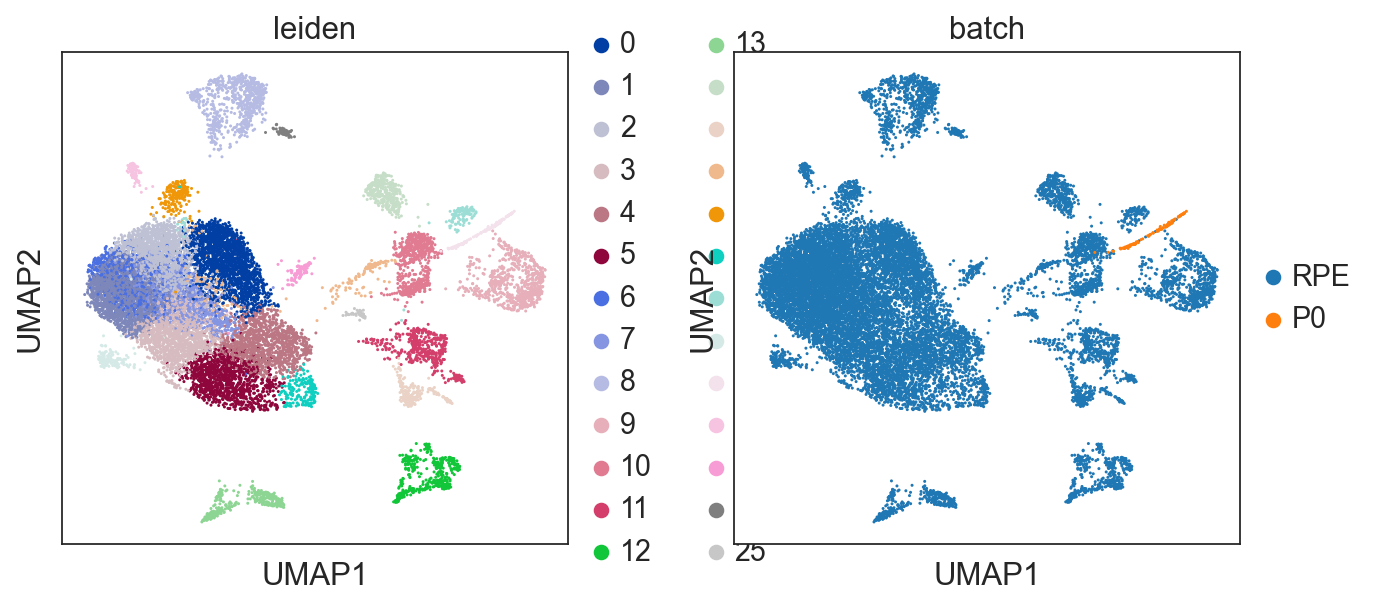

In [13]:

sce.pp.harmony_integrate(adata_combined, 'batch', max_iter_harmony=10, basis="X_pca")
sc.pp.neighbors(adata_combined, n_neighbors=35, n_pcs = 35, use_rep="X_pca_harmony")

#sce.pp.harmony_integrate(adata_combined, 'run', max_iter_harmony=20, basis="X_pca")
#sc.pp.neighbors(adata_combined, n_neighbors=40, n_pcs = 30, use_rep="X_pca_harmony")

sc.tl.leiden(adata_combined)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color = ["leiden", "batch"])

/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


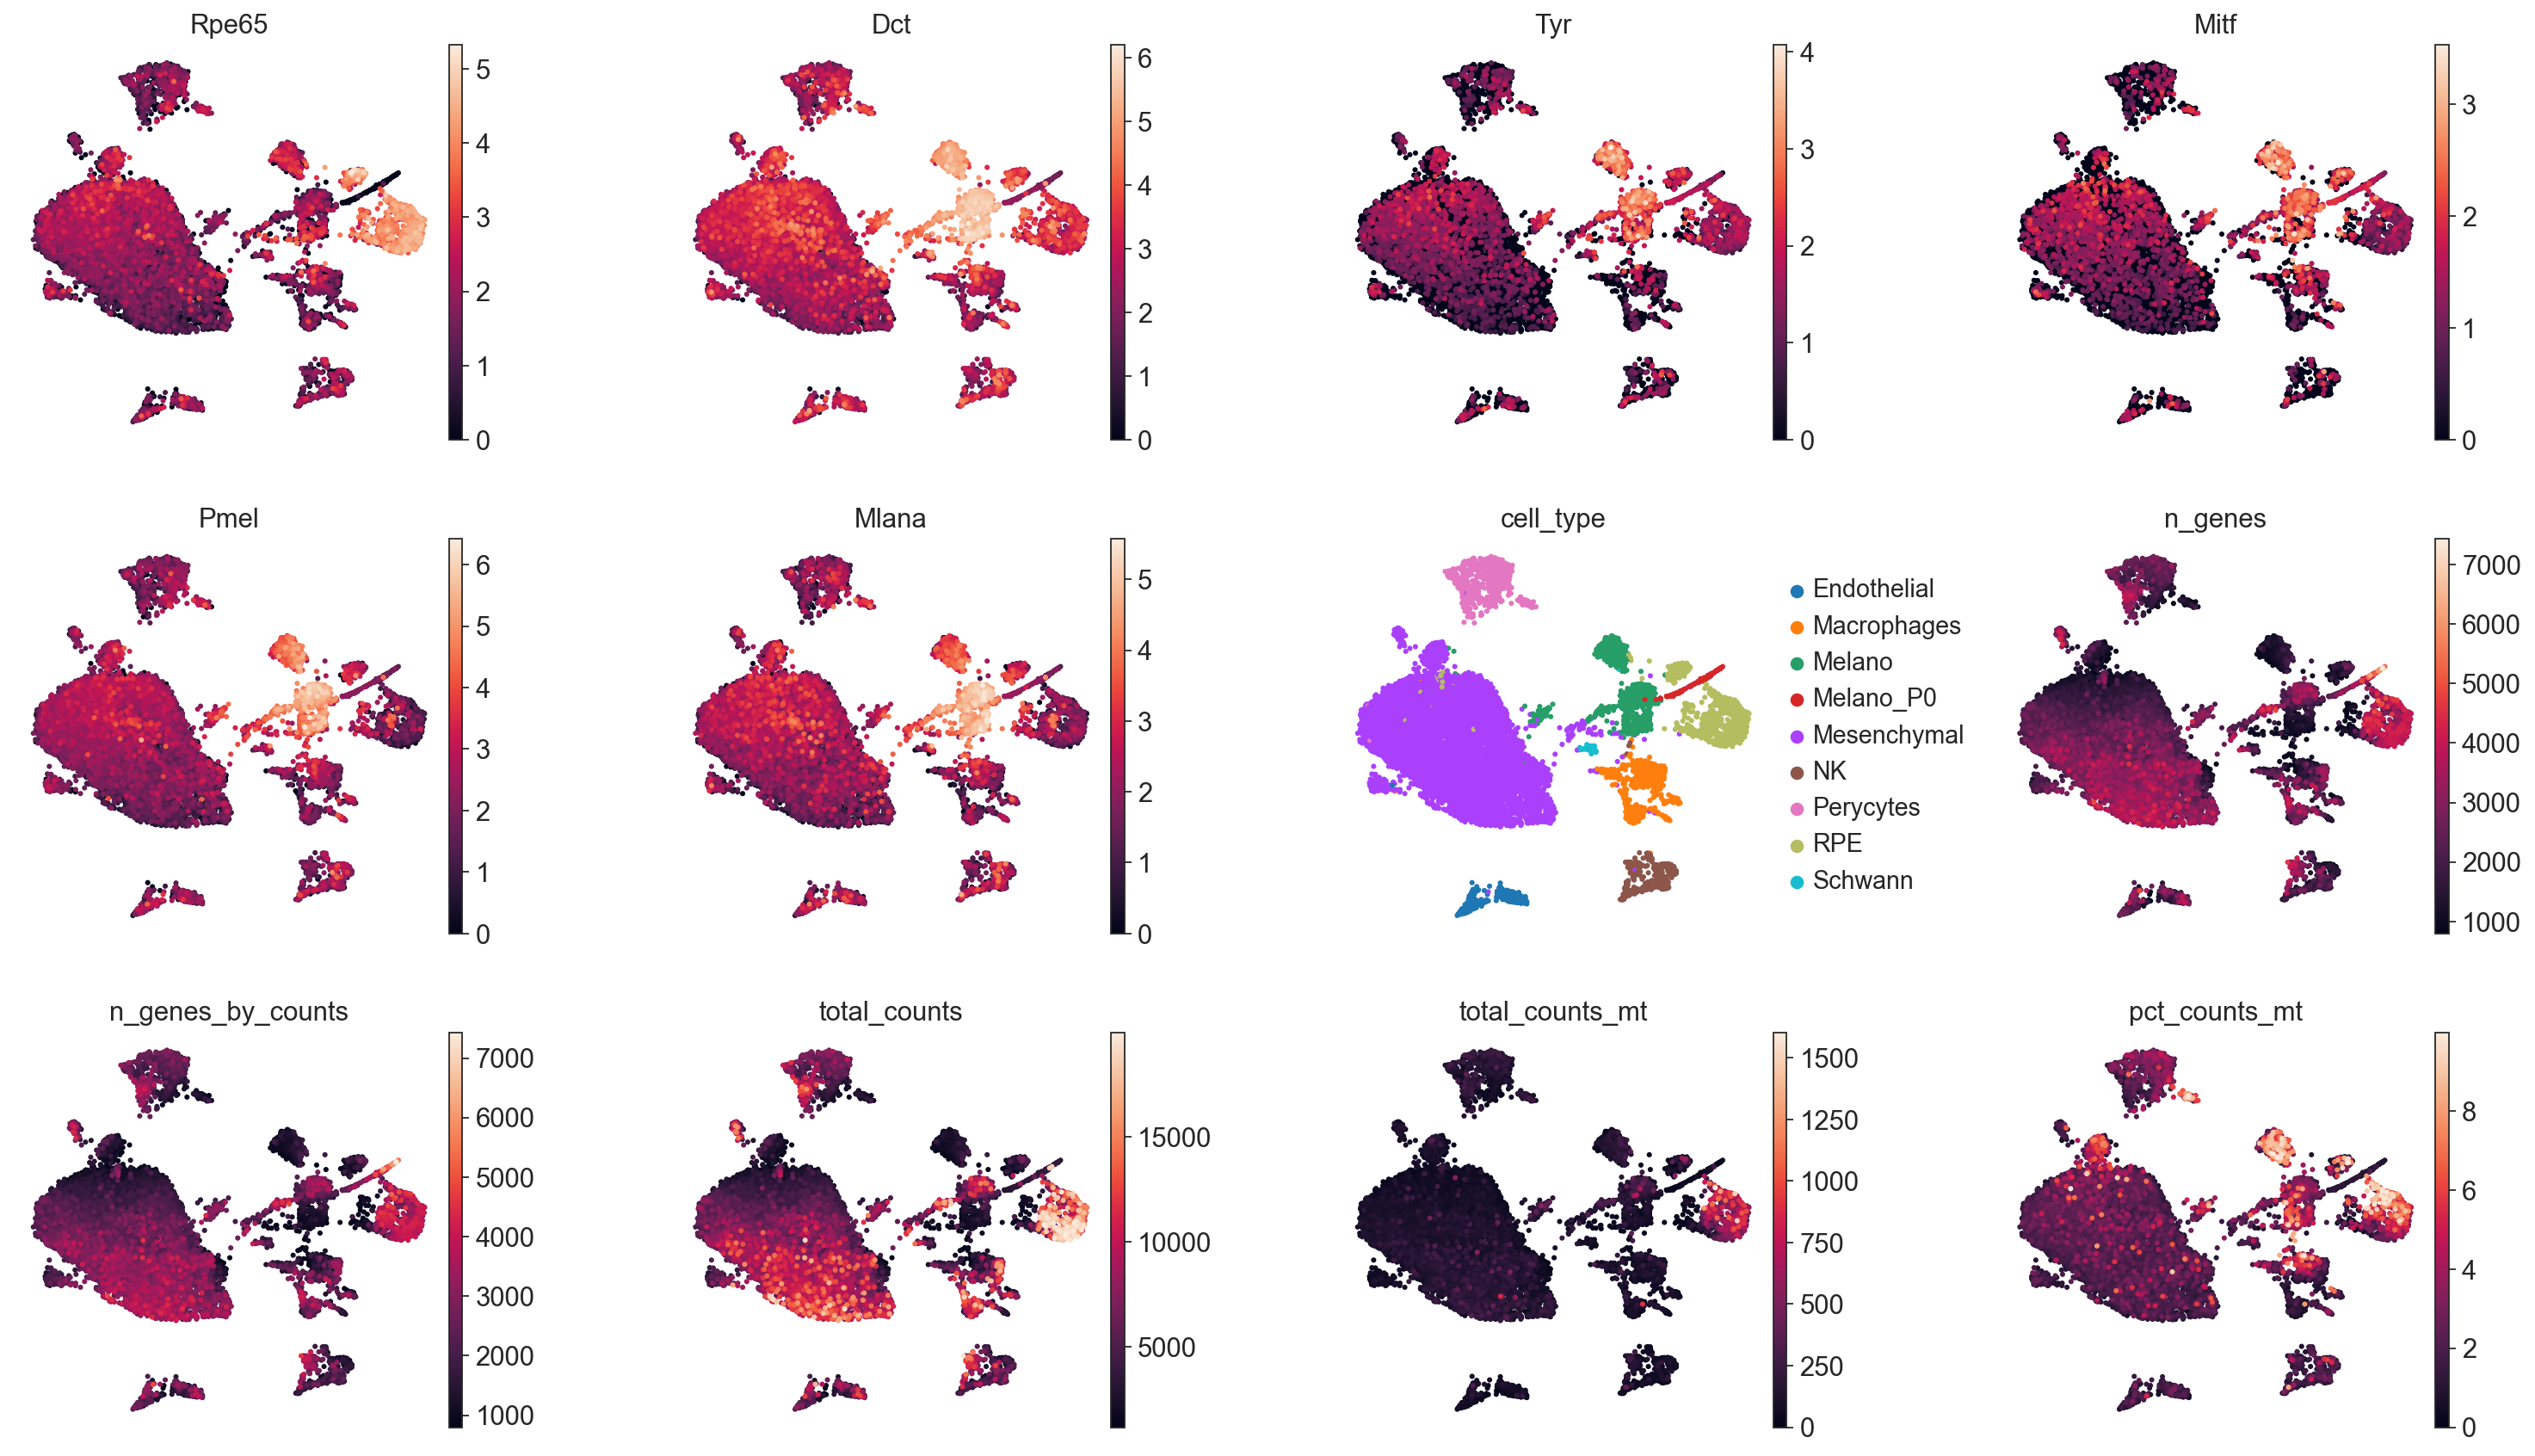

In [14]:
sc.pl.umap(adata_combined, color=["Rpe65", "Dct", "Tyr", "Mitf", "Pmel", "Mlana", "cell_type", 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'],size=30,
            wspace=0.4, frameon=False)

/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


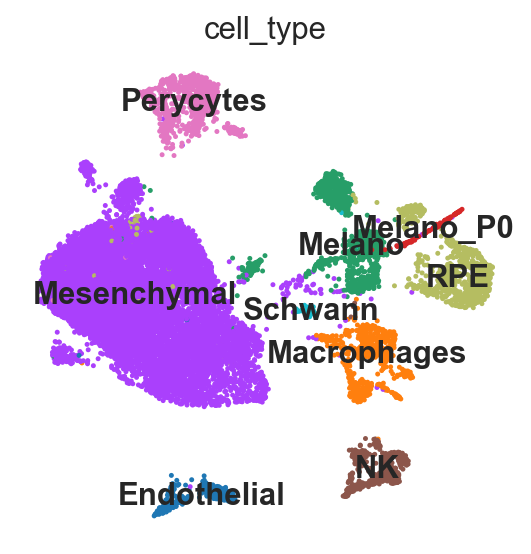

In [15]:
sc.pl.umap(adata_combined, color=[ 'cell_type'],
            wspace=0.4, frameon=False, use_raw=True, size=20, legend_loc='on data')

/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


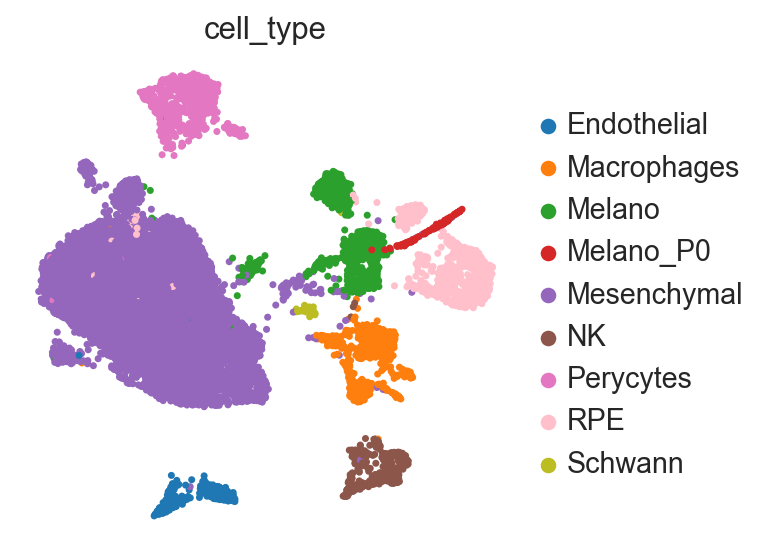

In [16]:
import matplotlib.pyplot as plt

# Define custom colors for the clusters
cluster_colors = [
    "#1f77b4",  # Blue for Endothelial
    "#ff7f0e",  # Orange for Macrophages
    "#2ca02c",  # Green for Melano
    "#d62728",  # Red for Melano_PD4_1
    "#9467bd",  # Purple for Mesenchymal
    "#8c564b",  # Brown for NK
    "#e377c2",  # Pink for Pericytes
    "pink",  # Gray for RPE
    "#bcbd22",  # Yellow for Schwann
]

# Update colors for 'cell_type'
sc.pl.umap(
    adata_combined,
    color='cell_type',
    palette=cluster_colors,
    wspace=0.4,
    frameon=False,
    size=40,
    show=False  # Prevent automatic plot display
)

# Save the updated plot as a PDF
plt.savefig("pd0.pdf", format="pdf", bbox_inches="tight")


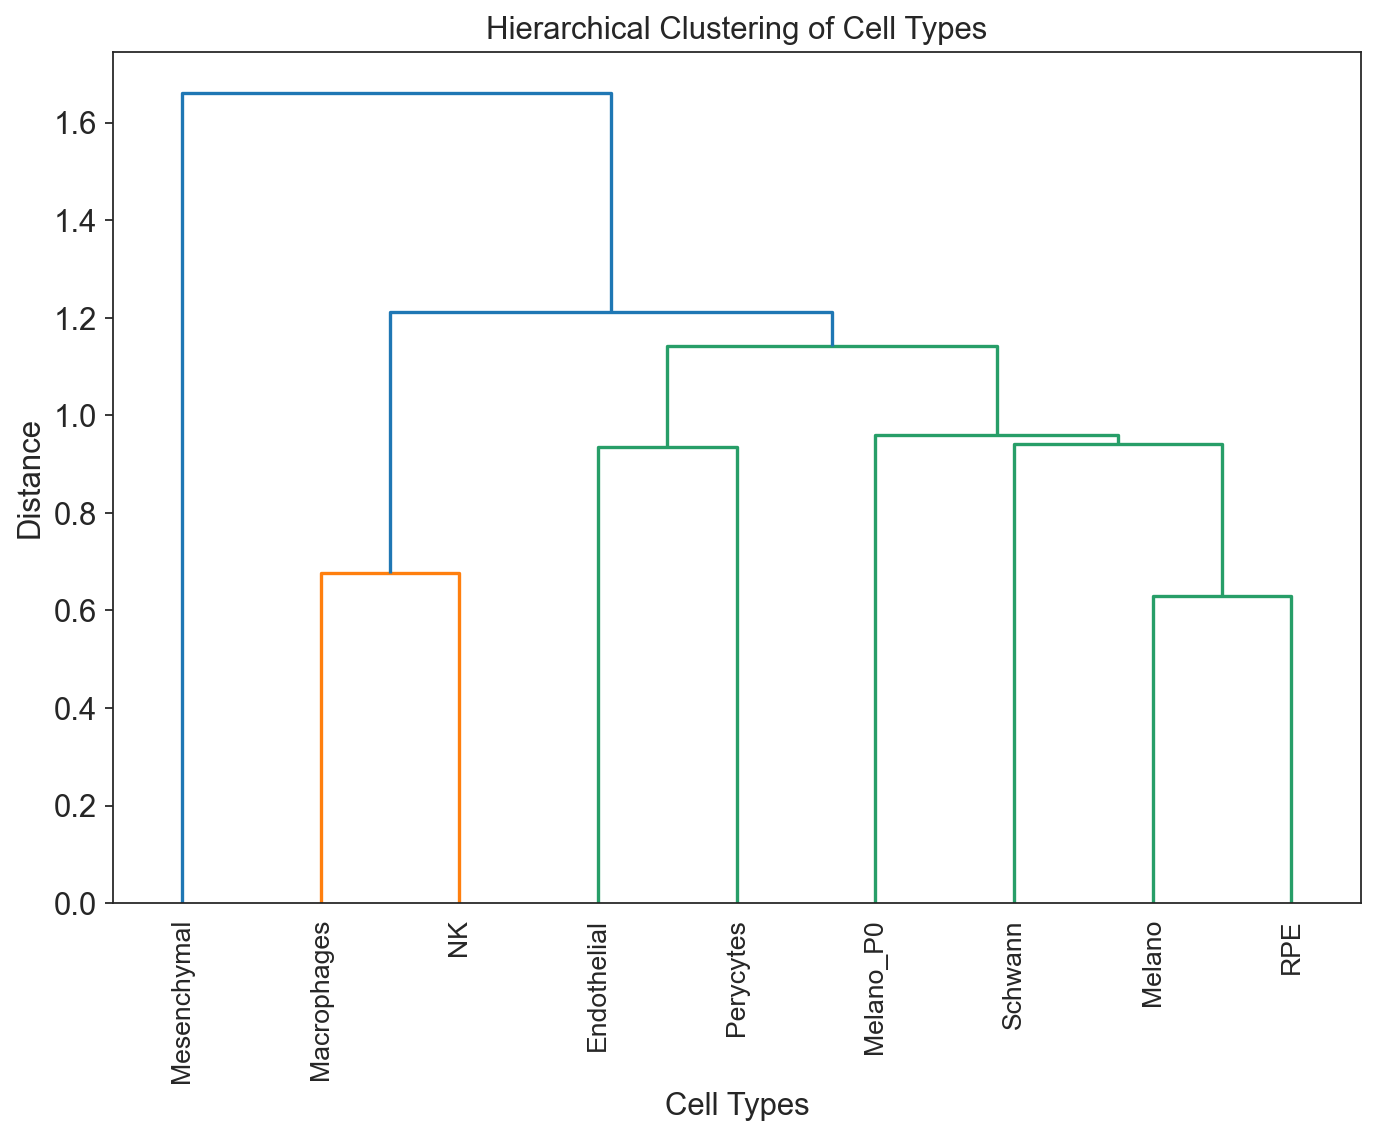

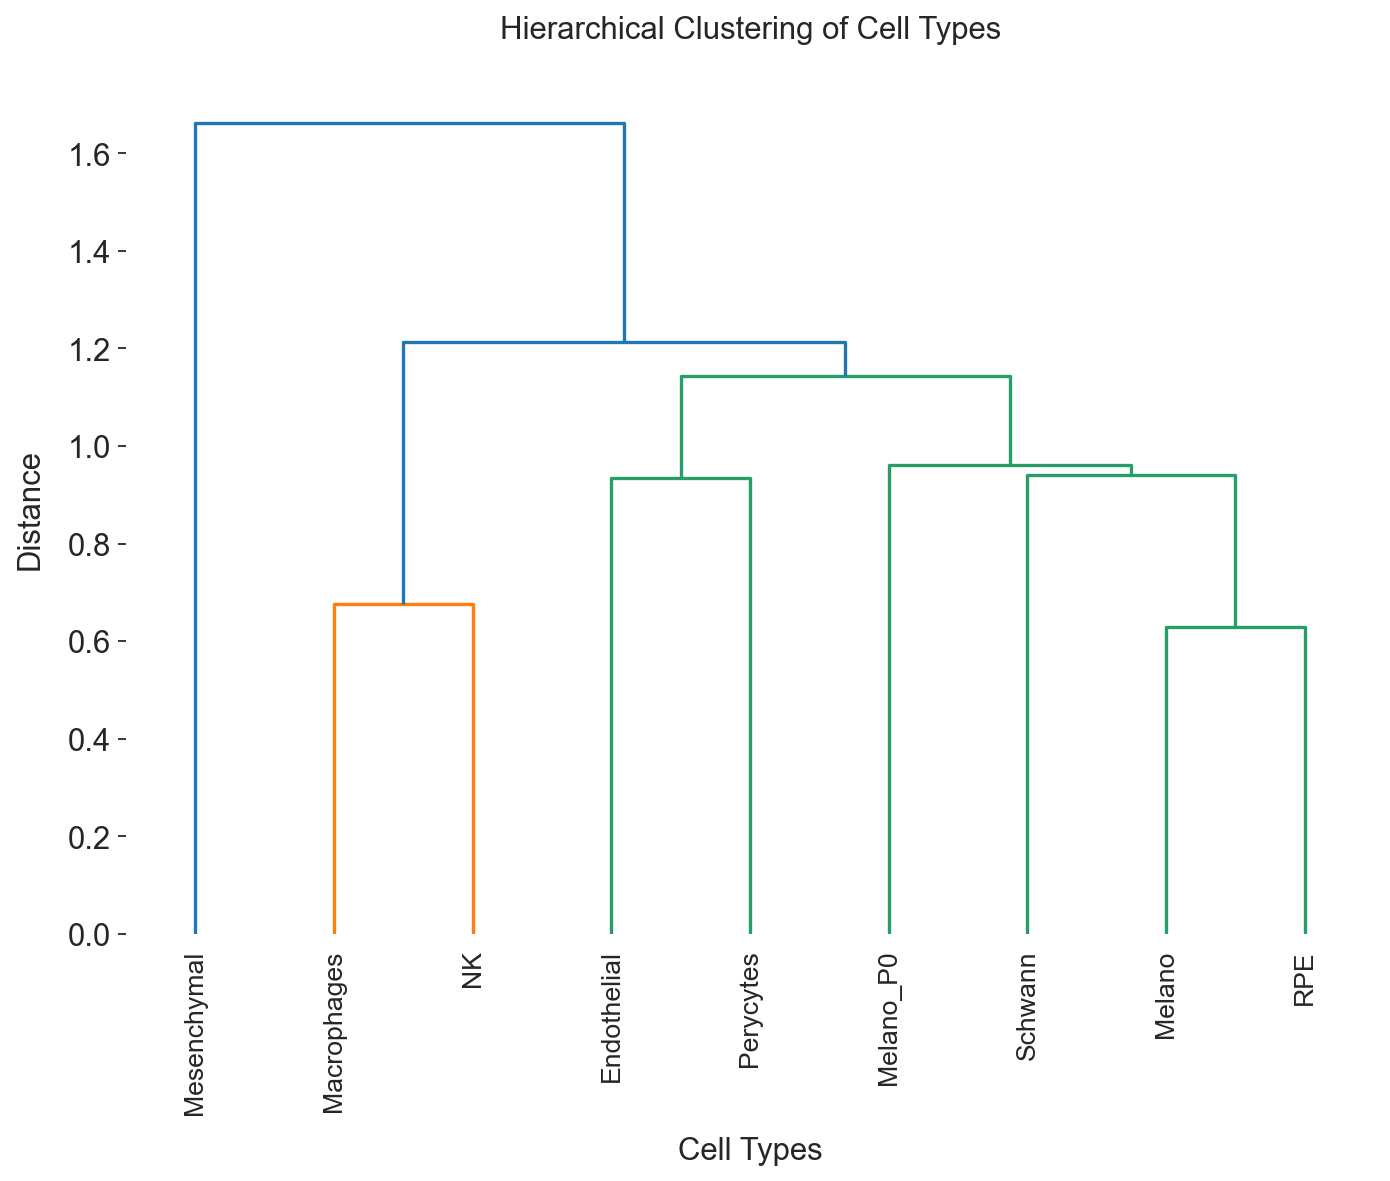

In [17]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Aggregate gene expression by cell type
adata_combined.obs['cell_type'] = adata_combined.obs['cell_type'].astype('category')  # Ensure 'cell_type' is categorical
mean_expression = adata_combined.to_df().groupby(adata_combined.obs['cell_type']).mean()  # Mean expression per cell type

from scipy.spatial.distance import pdist, squareform

# Compute pairwise distances (e.g., correlation distance)
distance_matrix = pdist(mean_expression, metric='correlation')  # Can use 'euclidean', 'cosine', etc.


# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # Use 'ward', 'average', or 'complete' linkage

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linkage_matrix, 
    labels=mean_expression.index,  # Use cell type names as labels
    leaf_rotation=90, 
    leaf_font_size=12
)
plt.title("Hierarchical Clustering of Cell Types")
plt.xlabel("Cell Types")
plt.ylabel("Distance")
plt.show()


# Plot the dendrogram without a frame
plt.figure(figsize=(10, 7))
dendrogram(
    linkage_matrix, 
    labels=mean_expression.index,  # Use cell type names as labels
    leaf_rotation=90, 
    leaf_font_size=12
)
plt.title("Hierarchical Clustering of Cell Types", pad=20)
plt.xlabel("Cell Types", labelpad=10)
plt.ylabel("Distance", labelpad=10)

# Remove the frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

In [18]:
genes=["Dcn", "Serpine2", "Igfbp4", "Lum", "Cygb", "Apod",
             "Ttr", "Ptgds", "Dct",  "Rgr", "Mlana", "Pmel",
              "Acta2", "Myh11", "Rgs5", "Tagln", "Mustn1", "Myl9",
             "Cd74", "H2-Aa",  "Lyz2", "Il1b",  "Cd83", "Tyrobp",  
             
              "Nkg7", "AW112010", "Rac2", "Vps37b", "Ms4a4b",  "Hcst",
             "Plvap", "Egfl7",  "Flt1",  "Cldn5", "Ptprb", "Plpp1",
            "Gfra3", "Kcna1",  "Plp1", "Gpm6b", "Prnp", "Dbi"]

In [19]:
adata_combined2=adata_combined.copy()

In [20]:
# Merging Melano clusters 

In [21]:
import pandas as pd

# Inspect the unique cell types
print(adata_combined2.obs['cell_type'].unique())

# Define which clusters should be merged (e.g., all starting with "Melano")
melano_clusters = ['Melano', 'Melano_P0']  # Adjust based on the actual names in your data

# Create a new column with updated cell types
adata_combined2.obs['cell_type_merged'] = adata_combined2.obs['cell_type']

# Update the new column: merge Melano clusters
adata_combined2.obs['cell_type_merged'] = adata_combined2.obs['cell_type_merged'].replace(
    melano_clusters, 'Melano_combined'
)

# Verify the update
print(adata_combined2.obs['cell_type_merged'].unique())


['Melano', 'Perycytes', 'Mesenchymal', 'NK', 'Macrophages', 'Endothelial', 'RPE', 'Schwann', 'Melano_P0']
Categories (9, object): ['Endothelial', 'Macrophages', 'Melano', 'Melano_P0', ..., 'NK', 'Perycytes', 'RPE', 'Schwann']
['Melano_combined', 'Perycytes', 'Mesenchymal', 'NK', 'Macrophages', 'Endothelial', 'RPE', 'Schwann']
Categories (8, object): ['Endothelial', 'Macrophages', 'Melano_combined', 'Mesenchymal', 'NK', 'Perycytes', 'RPE', 'Schwann']


Index(['Melano_combined', 'RPE', 'Mesenchymal', 'Perycytes', 'Macrophages',
       'NK', 'Endothelial', 'Schwann'],
      dtype='object')


/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


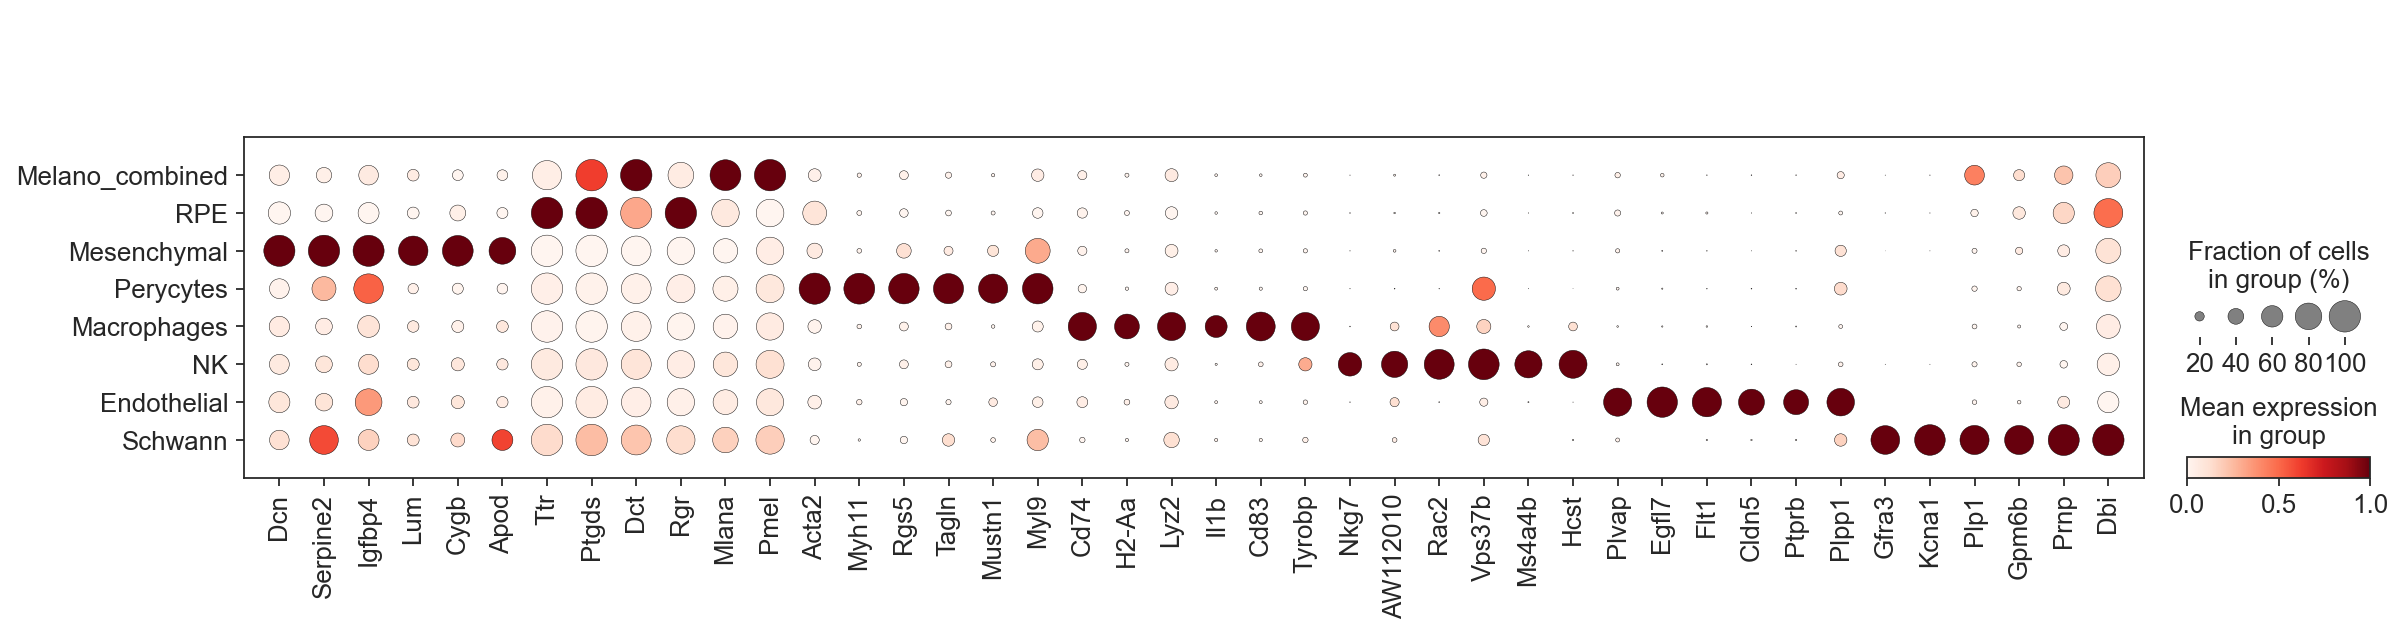

In [22]:
import pandas as pd

# Define the desired order for the clusters
desired_order = [

    'Melano_combined',
     'RPE',
     'Mesenchymal',
    'Perycytes',
    'Macrophages',
    'NK',
    'Endothelial',
    'Schwann'
]

# Set the categorical order in the 'cell_type_merged' column
adata_combined2.obs['cell_type_merged'] = pd.Categorical(
    adata_combined2.obs['cell_type_merged'], 
    categories=desired_order, 
    ordered=True
)

# Verify the updated order
print(adata_combined2.obs['cell_type_merged'].cat.categories)

# Plot the dot plot with the specified order
sc.pl.dotplot(
    adata_combined2,
    var_names=genes,  # Replace with your gene list
    groupby='cell_type_merged',
    standard_scale='var'
)


/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


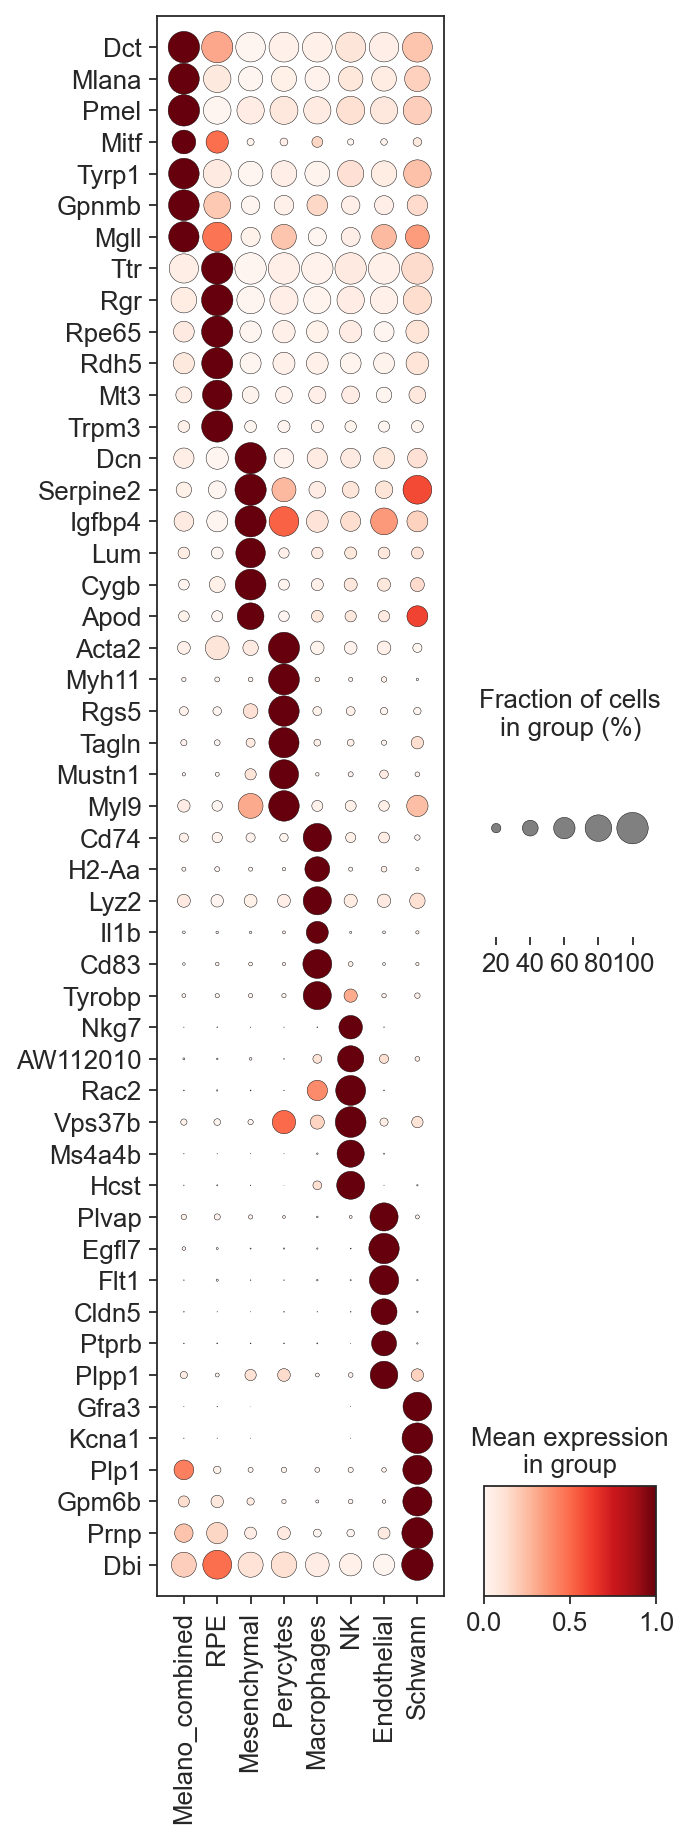

In [23]:
genes1=[
       "Dct", "Mlana", "Pmel",'Mitf','Tyrp1', 'Gpnmb','Mgll',
        "Ttr",   "Rgr","Rpe65", 'Rdh5','Mt3','Trpm3',
  "Dcn", "Serpine2", "Igfbp4", "Lum", "Cygb", "Apod",
           "Acta2", "Myh11", "Rgs5", "Tagln", "Mustn1", "Myl9",
             "Cd74", "H2-Aa",  "Lyz2", "Il1b",  "Cd83", "Tyrobp", 
              "Nkg7", "AW112010", "Rac2", "Vps37b", "Ms4a4b",  "Hcst",
             "Plvap", "Egfl7",  "Flt1",  "Cldn5", "Ptprb", "Plpp1",
            "Gfra3", "Kcna1",  "Plp1", "Gpm6b", "Prnp", "Dbi"]

sc.pl.dotplot(
    adata_combined2,
    var_names=genes1,  # Replace with your gene list
    groupby='cell_type_merged',
    standard_scale='var', 
    figsize=(4, 13),  # Adjust the figsize to accommodate the vertical layout
    swap_axes=True,  # This makes the plot vertical
   # save='P0_png_dot_6_vertical.png'
)


# CASSIOPEA PREP

In [24]:
adata_hvg=adata_combined.copy()

import pandas as pd
import numpy as np
import scipy.sparse as sp

# Assuming 'adata' is your AnnData object and 'leiden' is the clustering annotation
# Create a DataFrame to store the results
cluster_gene_expression = {}

# Iterate over each cluster
for cluster in adata_hvg.obs['cell_type'].unique():
    # Subset the adata object to the current cluster
    cluster_data = adata_hvg[adata_hvg.obs['cell_type'] == cluster]
    
    # Ensure cluster_data.X is dense if it's sparse
    if sp.issparse(cluster_data.X):
        cluster_data_matrix = cluster_data.X.toarray()
    else:
        cluster_data_matrix = cluster_data.X
    
    # Calculate the fraction of cells expressing each gene
    fraction_expressing = (cluster_data_matrix > 0).sum(axis=0) / cluster_data.n_obs
    
    # Filter genes expressed in at least 10% of the cells
    genes_expressed = np.array(adata_hvg.var_names)[fraction_expressing >0.1]
    
    # Store the results in a dictionary
    cluster_gene_expression[cluster] = genes_expressed

# Convert the results into a readable format
cluster_gene_expression_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k, v in cluster_gene_expression.items()])
)

# Save the results to a CSV file
#cluster_gene_expression_df.to_csv("genes_expressed_in_clusters.csv", index=False)

#print("Genes expressed in at least 10% of cells for each cluster saved to 'genes_expressed_in_clusters.csv'.")

In [25]:
cluster_gene_expression_df

,Melano,Perycytes,Mesenchymal,NK,Macrophages,Endothelial,RPE,Schwann,Melano_P0
0,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik,1110004F10Rik
1,1810058I24Rik,1200007C13Rik,1200007C13Rik,1600014C10Rik,1810058I24Rik,1810058I24Rik,1600014C10Rik,1200007C13Rik,1700001O22Rik
2,A830019P07Rik,1810058I24Rik,1810058I24Rik,1810058I24Rik,AW112010,AU021092,1810058I24Rik,1810058I24Rik,1810058I24Rik
3,AY036118,2210407C18Rik,AY036118,AW112010,AY036118,AW112010,2310015A10Rik,AY036118,1810065E05Rik
4,Abat,AW011738,Abat,AY036118,Abcd1,AY036118,4933429O19Rik,Acadsb,2310015A10Rik
...,...,...,...,...,...,...,...,...,...
916,NaN,NaN,NaN,NaN,Zfp207,NaN,NaN,NaN,NaN
917,NaN,NaN,NaN,NaN,Zfp36,NaN,NaN,NaN,NaN
918,NaN,NaN,NaN,NaN,Zfp36l1,NaN,NaN,NaN,NaN
919,NaN,NaN,NaN,NaN,Zfp445,NaN,NaN,NaN,NaN


In [26]:
with open('/home/julia/data/Scenic_database/Mouse/TF/allTFs_mm.txt', 'r') as file:
    list_tf = []
    for line in file.read().split('\n'):
            
                list_tf.append(line)
                
print(list_tf)

['Bcl6b', 'Zscan26', 'Mtf1', 'Klf9', 'Zic5', 'Zfp410', 'Zfp3', 'Zfp691', 'Zfp637', 'Egr3', 'Klf12', 'Bcl6', 'Tfap2a', 'Tfap2b', 'Tfap2c', 'Tfap2e', 'Arid3a', 'Arid5a', 'Ascl2', 'Tcf3', 'Bhlhe40', 'Myf6', 'Max', 'Mafk', 'Atf1', 'Jdp2', 'Mafb', 'Glis2', 'Plagl1', 'Osr2', 'Sp4', 'Klf7', 'Zbtb7b', 'Zic1', 'Egr1', 'Zfp281', 'Hic1', 'Zfp740', 'Osr1', 'Zbtb14', 'Zbtb12', 'Zscan4c', 'Zfp105', 'Zfp128', 'Zic2', 'Zic3', 'Zbtb3', 'E2f3', 'E2f2', 'Spi1', 'Elf3', 'Gabpa', 'Ehf', 'Spdef', 'Foxj3', 'Foxj1', 'Foxa2', 'Foxk1', 'Foxl1', 'Gata6', 'Gata3', 'Gata5', 'Gcm1', 'Six6', 'Nkx3-1', 'Hnf1a', 'Hoxa3', 'Irf9', 'Irf3', 'Irf4', 'Irf6', 'Irf5', 'Srf', 'Myb', 'Mybl1', 'Rxra', 'Hnf4a', 'Esrra', 'Nr2f2', 'Rara', 'Rfx4', 'Rfx7', 'Rfx3', 'Sp100', 'Gmeb1', 'Smad3', 'Tcf7', 'Hbp1', 'Cic', 'Bbx', 'Sox8', 'Tcf7l2', 'Sox17', 'Lef1', 'Sox30', 'Sox15', 'Sox5', 'Sox18', 'Sox12', 'Sox14', 'Tcf7l1', 'Sox21', 'Sox7', 'Sox11', 'Sry', 'Sox13', 'Sox4', 'Sox1', 'Eomes', 'Tbp', 'Cux1', 'Lhx2', 'Hoxb6', 'Hoxa10', 'Hoxa4', '

In [27]:
# Convert the list of transcription factors to a set for faster lookups
set_tf = set(list_tf)

In [28]:


# Create a DataFrame with transcription factors as rows and clusters as columns
tf_df = pd.DataFrame(index=list_tf, columns=cluster_gene_expression_df.columns)

# Populate the DataFrame
for cluster in cluster_gene_expression_df.columns:
    # Check if each TF is present in the cluster's gene list
    cluster_genes = set(cluster_gene_expression_df[cluster].dropna())  # Drop NaN values
    tf_df[cluster] = [gene in cluster_genes for gene in list_tf]

# Convert boolean values to True/False explicitly if necessary
tf_df = tf_df.applymap(bool)
tf_df

,Melano,Perycytes,Mesenchymal,NK,Macrophages,Endothelial,RPE,Schwann,Melano_P0
Bcl6b,False,False,False,False,False,False,False,False,False
Zscan26,False,False,False,False,False,False,False,False,False
Mtf1,False,False,False,False,False,False,False,False,False
Klf9,False,False,False,False,False,False,False,False,False
Zic5,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
Zscan4b,False,False,False,False,False,False,False,False,False
Zscan4e,False,False,False,False,False,False,False,False,False
Zswim1,False,False,False,False,False,False,False,False,False
Zxdb,False,False,False,False,False,False,False,False,False


In [29]:
# Assuming 'tf_df' is the DataFrame with True/False values
# Convert True/False to 1/0
tf_df = tf_df.astype(int)
tf_df
# Save the resulting DataFrame to a CSV file
#tf_df.to_csv("tf_presence_as_binary.csv")

#print("DataFrame with 1/0 representation saved to 'tf_presence_as_binary.csv'.")

,Melano,Perycytes,Mesenchymal,NK,Macrophages,Endothelial,RPE,Schwann,Melano_P0
Bcl6b,0,0,0,0,0,0,0,0,0
Zscan26,0,0,0,0,0,0,0,0,0
Mtf1,0,0,0,0,0,0,0,0,0
Klf9,0,0,0,0,0,0,0,0,0
Zic5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
Zscan4b,0,0,0,0,0,0,0,0,0
Zscan4e,0,0,0,0,0,0,0,0,0
Zswim1,0,0,0,0,0,0,0,0,0
Zxdb,0,0,0,0,0,0,0,0,0


In [30]:
# Assuming 'tf_df' is the DataFrame with True/False values
# Convert True/False to 1/0
tf_df = tf_df.astype(int)
tf_df
# Save the resulting DataFrame to a CSV file
#tf_df.to_csv("tf_presence_as_binary.csv")

#print("DataFrame with 1/0 representation saved to 'tf_presence_as_binary.csv'.")

,Melano,Perycytes,Mesenchymal,NK,Macrophages,Endothelial,RPE,Schwann,Melano_P0
Bcl6b,0,0,0,0,0,0,0,0,0
Zscan26,0,0,0,0,0,0,0,0,0
Mtf1,0,0,0,0,0,0,0,0,0
Klf9,0,0,0,0,0,0,0,0,0
Zic5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
Zscan4b,0,0,0,0,0,0,0,0,0
Zscan4e,0,0,0,0,0,0,0,0,0
Zswim1,0,0,0,0,0,0,0,0,0
Zxdb,0,0,0,0,0,0,0,0,0


In [31]:
# Assuming 'tf_df' is the DataFrame with 1/0 representation

# Filter rows where not all values are 0 or 1
filtered_tf_df = tf_df[(tf_df.sum(axis=1) != 0) & (tf_df.sum(axis=1) != tf_df.shape[1])]
filtered_tf_df
# Save the filtered DataFrame to a CSV file
#filtered_tf_df.to_csv("cassiopea_folders_24_12/filtered_tf_2000_hv.csv")

#print("Filtered DataFrame saved to 'filtered_tf_binary.csv'.")

,Melano,Perycytes,Mesenchymal,NK,Macrophages,Endothelial,RPE,Schwann,Melano_P0
Tfap2c,0,0,0,0,0,0,0,0,1
Bhlhe40,1,1,1,1,1,1,1,1,0
Mafb,0,1,1,0,1,1,0,1,1
Egr1,1,1,1,1,1,1,0,1,0
Spi1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
Id1,1,1,1,1,0,1,1,1,1
Mylk,1,1,1,1,1,1,0,1,1
Tagln2,1,1,1,1,1,1,0,1,1
Zdhhc24,0,0,0,0,0,0,1,0,0


In [32]:
# Save the updated DataFrame to a CSV file
filtered_tf_df.to_csv("P0_CASSIOPEA.csv", index=True)


In [33]:
adata_combined.write_h5ad('p0_FINAL.h5ad')